# Clustering Project - German U-Boats of World War II

In [725]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, make_scorer
from sklearn.mixture import GaussianMixture

##### 
- Zdroj dat: https://www.kaggle.com/datasets/cormac42/ww2-u-boats
- Dataset obsahuje informace o německých ponorkách z druhé světové války.
- Data jsou scrapována z wikipedie.


## Preprocessing

In [726]:
# Load the data
df = pd.read_csv('uboats.csv')
df

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
0,U-1,1935,IIA,Klaus Ewerth,0,0,0,0,0,0,...,Struck a mine,https://en.wikipedia.org/wiki/German_submarine...,1935-06-29,2 patrols:1st patrol:15 – 29 March 19402nd pat...,2,NaN,0,"{'U-boat School Flotilla': ['1 July 1935 ', ' ...",1,U-boat School Flotilla
1,U-2,1935,IIA,"Hans Heidtmann,Heinrich Liebe,Helmut Rosenbaum...",0,0,0,0,0,0,...,Training boat,https://en.wikipedia.org/wiki/German_submarine...,1935-07-25,2 patrols:1st patrol:15 – 29 March 19402nd pat...,2,NaN,0,"{'U-boat School Flotilla': ['1 July 1935 ', ' ...",2,21st U-boat Flotilla
2,U-3,1935,IIA,"Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...",0,0,0,0,2,"2,348",...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1935-09-06,5 patrols:1st patrol:4 – 8 September 19392nd p...,5,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
3,U-4,1935,IIA,Heinz-Otto Schultze,1,"1,090",0,0,3,"5,133",...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1935-08-17,4 patrols:1st patrol:4 – 14 September 19392nd ...,4,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
4,U-5,1935,IIA,Heinrich Lehmann-Willenbrock,0,0,0,0,0,0,...,Accident,https://en.wikipedia.org/wiki/German_submarine...,1935-08-31,2 patrols:1st patrol:24 August – 8 September 1...,2,NaN,0,{'U-boat School Flotilla': ['1 September 1935 ...,2,21st U-boat Flotilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,U-4707,1945,XXIII,NaN,0,0,0,0,0,0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-02-20,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['20 February ', ' 5 M...",1,5th U-boat Flotilla
1149,U-4709,1945,XXIII,NaN,0,0,0,0,0,0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-03-03,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['3 March ', ' 4 May 1...",1,5th U-boat Flotilla
1150,U-4710,1945,XXIII,Ludwig von Friedeburg,0,0,0,0,0,0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-05-01,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['1 ', ' 5 May 1945']}",1,5th U-boat Flotilla
1151,U-4711,1945,XXIII,NaN,0,0,0,0,0,0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-03-21,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['21 March ', ' 4 May ...",1,5th U-boat Flotilla


### Popis datasetu
- Dataset obsahuje 1153 ponerek vyrobených Německem od roku 1935 do roku 1945.
- Neobsahuje ponorky, které byly německem ukořistěny a použity německým námořnictvem.

### Popis sloupců
- **Name** - název ponorky
- **Year** - rok, kdy byla ponorka spuštěna na vodu
- **Type** - typ ponorky
- **Notable Commanders** - významní velitelé ponorky
- **Warships_sunk_n_total_loss_No** - počet potopených válečných lodí
- **Warships_sunk_n_total_loss_Tons-n-GRT** - celková tonáž potopených válečných lodí
- **Warships_Damaged_No** - počet válečných lodí, které byly poškozeny
- **Warships_Damaged_Tons-n-GRT** - celková tonáž válečných lodí, které byly poškozeny
- **Merchant_Ships_sunk_No** - počet potopených obchodních lodí
- **Merchant_Ships_sunk_GRT** - celková tonáž potopených obchodních lodí
- **Merchant_Ships_Damaged_No** - počet obchodních lodí, které byly poškozeny
- **Merchant_Ships_Damaged_GRT** - celková tonáž obchodních lodí, které byly poškozeny
- **Merchant_Ships_total_loss_No** - počet obchodních lodí, které byly ztraceny
- **Merchant_Ships_total_loss_GRT** - celková tonáž obchodních lodí, které byly ztraceny
- **Fate_Event** - osud ponorky
- **Fate_Date** - datum, kdy k osudu ponorky došlo
- **Notes** - poznámky(Např. název lodě, která ponorku potopila; způsob potopení; způsob použití; atd.)
- **URL** - odkaz na wikipedii
- **Commissioned** - datum, kdy byla ponorka zařazena do služby
- **Patrols** - informace o hlídkách vykonaných ponorkou ve formátu: 'Počet hlídek:číslo hlídky:datum začátku - datum konce číslo hlídky:datum začátku - datum konce ...'
- **Patrols_Count** - počet hlídek
- **Wolfpacks** - slovník s informacemi o vlčích smečkách, ve kterých ponorka operovala ve formátu: {'Jméno vlčí smečky': 'datum začátku - datum konce'}
- **Wolfpacks_Count** - počet vlčích smeček
- **Flotilla** - flotily, ke kterým ponorka patřila
- **Flotilla_Count** - počet flotil ke kterým ponorka patřila
- **Last_Flotilla** - poslední flotila, ke které ponorka patřila

### Encoding číselných atributů
- Některé atributy s čísly jsou načteny jako stringy
    - Tyto atributy budou převedeny na čísla
- Atributy s datumy budou převedeny na samostatné sloupce pro rok, měsíc a den
    - Bude vytvořen sloupec pro kosinus měsíce a dne, aby model mohl pochopit cyklickou povahu času
        - Kdy například prosinec a leden mají kladnou hodnotu blízko sebe a červenec a srpen zápornou blízko sebe

In [727]:
# convert columns with numbers which were read as strings to numbers
df['Warships_sunk_n_total_loss_Tons-n-GRT'] = df['Warships_sunk_n_total_loss_Tons-n-GRT'].str.replace(',', '').astype(float)
df['Warships_Damaged_Tons-n-GRT'] = df['Warships_Damaged_Tons-n-GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_sunk_GRT'] = df['Merchant_Ships_sunk_GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_damaged_GRT'] = df['Merchant_Ships_damaged_GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_total_loss_GRT'] = df['Merchant_Ships_total_loss_GRT'].str.replace(',', '').astype(float)

In [728]:
df.describe()

,Year,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,Merchant_Ships_damaged_No,Merchant_Ships_damaged_GRT,Merchant_Ships_total_loss_No,Merchant_Ships_total_loss_GRT,Patrols_Count,Wolfpacks_Count,Flotilla_Count
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,1942.150911,0.263660,622.280139,0.050304,275.049436,2.319167,11554.209020,0.300954,2105.466609,0.061578,387.900260,3.015611,1.754553,2.121422
std,1.846483,0.698366,3146.665601,0.255295,2235.575175,5.824886,30600.823267,0.834670,6127.362156,0.298474,1972.007084,3.604313,3.431312,0.926557
min,1935.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1941.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1942.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000
75%,1943.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8133.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,3.000000
max,1945.000000,10.000000,46440.000000,3.000000,39346.000000,53.000000,299477.000000,8.000000,62751.000000,3.000000,24338.000000,20.000000,21.000000,7.000000


### Missing values
- Notable Commanders - ponorky nemusí mít významné velitele
- Wolfpacks - ponorky nemusí být součástí vlčí smečky
- Patrols - ponorky nemusí mít žádné vykonané hlídky
- Notes - poznámky nejsou povinné
- Fate_Date
    - Jedná se o ponorky:
        - Všechny 3 úmyslně zničeny během operace Regenbogen (Datum nejspíš kolem 2-3. května 1945)
        - U-2505 - Doplněno z textu - 3. května 1945
        - U-3004 - Doplněno z textu - 2. května 1945
        - U-3506 - Doplněno z textu - 2. května 1945
- Commissioned
    - Jedná se o ponorky 
        - U-118 - Na wikipedii jsou uvedené 2 datumy, 23. září 1941 a 6. Prosince 1941
                - Bylo vybráno datum 6 Prosince 1941, protože je z důvěryhodnějšího zdroje
        - U-128 - Nejspíš chyba parseru, nejspíš protože na wikipedii je za datumem uvedeno, kým byla ponorka uváděna na vodu
                - opraveno na 12. května 1941

In [729]:
# print table where will be each column with its name, type, number of missing values and unique values
def print_columns_descrbition(df):
    tab = pd.DataFrame(columns=['column_name', 'type', 'missing', 'unique'])
    for col in df.columns:
        new_row = pd.DataFrame({'column_name': [col], 'type': [df[col].dtype], 'missing': [df[col].isnull().sum()], 'unique': [df[col].nunique()]})
        tab = pd.concat([tab, new_row], ignore_index=True)
    return tab

# print number of rows and columns
print(f"Table with some description of columns:\nOriginal dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print_columns_descrbition(df)

Table with some description of columns:
Original dataset has 1153 rows and 26 columns


,column_name,type,missing,unique
0,Name,object,0,1153
1,Year,int64,0,11
2,Type,object,0,24
3,Notable Commanders,object,935,169
4,Warships_sunk_n_total_loss_No,int64,0,7
5,Warships_sunk_n_total_loss_Tons-n-GRT,float64,0,156
6,Warships_Damaged_No,int64,0,4
7,Warships_Damaged_Tons-n-GRT,float64,0,46
8,Merchant_Ships_sunk_No,int64,0,39
9,Merchant_Ships_sunk_GRT,float64,0,423


#### Chybné/nevhodné hodnoty
- U-92 - datum osudu může mít několik datumů
    - vybrán 12. listopad 1944 - datum vyřazení z provozu
- U-53 
    - datum osudu je 23 / 24 února 1940
    - bude vybráno 23. února 1940
- U-195, U-219, U-1197, U-1232
    - datum osudu je bez uvedeného dne
        - bude doplněn 15. den(prostřední den měsíce)
- U-984
    - u data osudu je napsáno, že se jedná o přibližnou hodnotu
        - odstranění komentáře
- U některých ponorek je uvedeno více osudných událostí, byla vybrána první
    - U-239 - 24. července 1944, 
    - U-952 - 12. července 1944, vyřazena z provozu
    - U-998 - 27. června 1944, vyřazena z provozu
    - U-1000 - 29. září 1944, vyřazena z provozu
- U-228 
    - u data osudu uveden rok 1944 - 1945
    - opraveno na  4. října 1944, ponorka byla potopena
- U-3501
    - u data osudu není jistý den
    - vybrán jeden z možných dnů, 5. května 1945

In [730]:
df_encoded = df.copy()

In [731]:
# show rows with missinf commission date
df_encoded[df_encoded['Commissioned'].isnull()]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
113,U-118,1941,XB,NaN,1,925.0,0,0.0,3,14064.0,...,US Avenger aircraft,https://en.wikipedia.org/wiki/German_submarine...,NaN,4 patrols:1st patrol:19 September - 16 October...,4,"{'Wotan': ['5', '7 October 1942'], 'Westwall':...",3,{'4th U-boat Flotilla': ['6 December 1941 - 30...,3,12th U-boat Flotilla
123,U-128,1941,IXC,Ulrich Heyse,0,0.0,0,0.0,12,83639.0,...,USS Moffett & USS Jouett,https://en.wikipedia.org/wiki/German_submarine...,NaN,6 patrols:1st patrol11 – 24 December 19412nd p...,6,NaN,0,"{'2nd U-boat Flotilla': ['12 May 1941 ', ' 17 ...",1,2nd U-boat Flotilla


In [732]:
df_encoded.loc[df_encoded['Name'] == 'U-118', 'Commissioned'] = pd.to_datetime('1941-12-06')
df_encoded.loc[df_encoded['Name'] == 'U-128', 'Commissioned'] = pd.to_datetime('1941-05-12')

df_encoded[df_encoded['Commissioned'].isnull()]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla


In [733]:
# show rows with missing fate date
df_encoded[df_encoded['Fate_Date'].isnull()]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
1028,U-2505,1944,XXI,NaN,0,0.0,0,0.0,0,0.0,...,Elbe II bunker,https://en.wikipedia.org/wiki/German_submarine...,1944-11-07,NaN,0,NaN,0,"{'31st U-boat Flotilla': ['7 November 1944 ', ...",1,31st U-boat Flotilla
1074,U-3004,1944,XXI,NaN,0,0.0,0,0.0,0,0.0,...,Elbe II bunker,https://en.wikipedia.org/wiki/German_submarine...,1944-08-30,NaN,0,NaN,0,"{'4th U-boat Flotilla': ['30 August 1944 ', ' ...",1,4th U-boat Flotilla
1117,U-3506,1944,XXI,Gerhard Thäter,0,0.0,0,0.0,0,0.0,...,Elbe II bunker,https://en.wikipedia.org/wiki/German_submarine...,1944-10-16,NaN,0,NaN,0,"{'8th U-boat Flotilla': ['16 October 1944 ', '...",2,5th U-boat Flotilla


In [734]:
# fill missing fate date as described above
df_encoded.loc[df_encoded['Name'] == 'U-2505', 'Fate_Date'] = '3 May 1945'
df_encoded.loc[df_encoded['Name'] == 'U-3004', 'Fate_Date'] = '2 May 1945'
df_encoded.loc[df_encoded['Name'] == 'U-3506', 'Fate_Date'] = '2 May 1945'

df_encoded[df_encoded['Fate_Date'].isnull()]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla


In [735]:
# correct fate date for U-92 as described above
df_encoded.loc[df_encoded['Name'] == 'U-92', 'Fate_Date'] = '12 November 1944'
df_encoded.loc[df_encoded['Name'] == 'U-92', 'Fate_Event'] = 'Decommissioned'

In [736]:
# replace 23 / 24 February 1940 with 23 February 1940 on U-53 as described above
df_encoded.loc[df_encoded['Name'] == 'U-53', 'Fate_Date'] = '23 February 1940'

df_encoded[df_encoded['Name'] == 'U-195']

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
190,U-195,1942,IXD1,NaN,0,0.0,0,0.0,2,14391.0,...,Became Japanese sub I-506,https://en.wikipedia.org/wiki/German_submarine...,1942-09-05,3 patrols:1st patrol:20 March – 23 July 19432n...,3,NaN,0,"{'4th U-boat Flotilla': ['5 September 1942 ', ...",3,33rd U-boat Flotilla


In [737]:
# find fate date without specified day - has only 1 space
df_encoded[df_encoded['Fate_Date'].str.count(' ') == 1]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
190,U-195,1942,IXD1,NaN,0,0.0,0,0.0,2,14391.0,...,Became Japanese sub I-506,https://en.wikipedia.org/wiki/German_submarine...,1942-09-05,3 patrols:1st patrol:20 March – 23 July 19432n...,3,NaN,0,"{'4th U-boat Flotilla': ['5 September 1942 ', ...",3,33rd U-boat Flotilla
214,U-219,1942,XB,NaN,0,0.0,0,0.0,0,0.0,...,Became Japanese sub I-505,https://en.wikipedia.org/wiki/German_submarine...,1942-12-12,2 patrols:1st patrol:22 October 1943 - 1 Janua...,2,NaN,0,{'4th U-boat Flotilla': ['12 December 1942 - 3...,3,33rd U-boat Flotilla
925,U-1197,1943,VIIC,NaN,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1943-12-02,NaN,0,NaN,0,"{'21st U-boat Flotilla': ['2 December 1943 ', ...",2,31st U-boat Flotilla
950,U-1232,1943,IXC/40,Kurt Dobratz,0,0.0,0,0.0,3,17355.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1944-03-08,1 patrol:10 November 1944 – 14 February 1945,1,NaN,0,"{'31st U-boat Flotilla': ['8 March ', ' 31 Oct...",2,33rd U-boat Flotilla


In [738]:
# for u-boats with fate date without day, set day to 15
df_encoded.loc[df_encoded['Fate_Date'].str.count(' ') == 1, 'Fate_Date'] ='15 ' + df_encoded.loc[df_encoded['Fate_Date'].str.count(' ') == 1, 'Fate_Date'] 

df_encoded[df_encoded['Name'] == 'U-195']

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
190,U-195,1942,IXD1,NaN,0,0.0,0,0.0,2,14391.0,...,Became Japanese sub I-506,https://en.wikipedia.org/wiki/German_submarine...,1942-09-05,3 patrols:1st patrol:20 March – 23 July 19432n...,3,NaN,0,"{'4th U-boat Flotilla': ['5 September 1942 ', ...",3,33rd U-boat Flotilla


In [739]:
# remove comment from fate date of U-984
df_encoded.loc[df_encoded['Name'] == 'U-984', 'Fate_Date'] = '2 August 1944'
df_encoded

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
0,U-1,1935,IIA,Klaus Ewerth,0,0.0,0,0.0,0,0.0,...,Struck a mine,https://en.wikipedia.org/wiki/German_submarine...,1935-06-29,2 patrols:1st patrol:15 – 29 March 19402nd pat...,2,NaN,0,"{'U-boat School Flotilla': ['1 July 1935 ', ' ...",1,U-boat School Flotilla
1,U-2,1935,IIA,"Hans Heidtmann,Heinrich Liebe,Helmut Rosenbaum...",0,0.0,0,0.0,0,0.0,...,Training boat,https://en.wikipedia.org/wiki/German_submarine...,1935-07-25,2 patrols:1st patrol:15 – 29 March 19402nd pat...,2,NaN,0,"{'U-boat School Flotilla': ['1 July 1935 ', ' ...",2,21st U-boat Flotilla
2,U-3,1935,IIA,"Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...",0,0.0,0,0.0,2,2348.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1935-09-06,5 patrols:1st patrol:4 – 8 September 19392nd p...,5,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
3,U-4,1935,IIA,Heinz-Otto Schultze,1,1090.0,0,0.0,3,5133.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1935-08-17,4 patrols:1st patrol:4 – 14 September 19392nd ...,4,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
4,U-5,1935,IIA,Heinrich Lehmann-Willenbrock,0,0.0,0,0.0,0,0.0,...,Accident,https://en.wikipedia.org/wiki/German_submarine...,1935-08-31,2 patrols:1st patrol:24 August – 8 September 1...,2,NaN,0,{'U-boat School Flotilla': ['1 September 1935 ...,2,21st U-boat Flotilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,U-4707,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-02-20,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['20 February ', ' 5 M...",1,5th U-boat Flotilla
1149,U-4709,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-03-03,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['3 March ', ' 4 May 1...",1,5th U-boat Flotilla
1150,U-4710,1945,XXIII,Ludwig von Friedeburg,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-05-01,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['1 ', ' 5 May 1945']}",1,5th U-boat Flotilla
1151,U-4711,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1945-03-21,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['21 March ', ' 4 May ...",1,5th U-boat Flotilla


In [740]:
# show unique fate events
df_encoded['Fate_Event'].unique()

array(['Sunk', 'Stricken', 'Scuttled', 'Scrapped', 'Missing',
       'Decommissioned', 'Captured', 'Surrendered', 'Broken up', 'Sold',
       'Interned, then sold', 'Ran aground & destroyed', 'Destroyed',
       'Interned', 'Grounded', 'Buried', 'Aground'], dtype=object)

In [741]:
# show fate date with len < 10
# print the names of u-boats with fate date with length less than 10
df_encoded[df_encoded['Fate_Date'].str.len() < 10]['Fate_Event']

234    Broken up
809    Broken up
854     Scrapped
856     Scrapped
Name: Fate_Event, dtype: object

In [742]:
df_encoded[df_encoded['Fate_Date'].str.len() < 10]['Name']

234     U-239
809     U-952
854     U-998
856    U-1000
Name: Name, dtype: object

In [743]:
# correct fate date for U-239, U-952, U-998, U-1000
df_encoded.loc[df_encoded['Name'] == 'U-239', 'Fate_Date'] = '24 July 1944'
df_encoded.loc[df_encoded['Name'] == 'U-952', 'Fate_Date'] = '12 July 1944'
df_encoded.loc[df_encoded['Name'] == 'U-952', 'Fate_Event'] = 'Decommissioned'
df_encoded.loc[df_encoded['Name'] == 'U-998', 'Fate_Date'] = '27 June 1944'
df_encoded.loc[df_encoded['Name'] == 'U-998', 'Fate_Event'] = 'Decommissioned'
df_encoded.loc[df_encoded['Name'] == 'U-1000', 'Fate_Date'] = '29 September 1944'
df_encoded.loc[df_encoded['Name'] == 'U-1000', 'Fate_Event'] = 'Decommissioned'

In [744]:
# show fate date which contains character '-'
df_encoded[df_encoded['Fate_Date'].str.contains('–')]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
223,U-228,1942,VIIC,NaN,0,0.0,0,0.0,0,0.0,...,Shot down 2 aircraft,https://en.wikipedia.org/wiki/German_submarine...,1942-09-12,6 patrols:1st patrol:6 February – 29 March 194...,6,NaN,0,"{'5th U-boat Flotilla': ['12 September 1942 ',...",2,6th U-boat Flotilla


In [745]:
# correct fate date and event for U-228
df_encoded.loc[df_encoded['Name'] == 'U-228', 'Fate_Date'] = '4 October 1944'
df_encoded.loc[df_encoded['Name'] == 'U-228', 'Fate_Event'] = 'Sunk'

In [746]:
df_encoded[df_encoded['Fate_Date'].str.contains('or')]

,Name,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,...,Notes,URL,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
1112,U-3501,1944,XXI,NaN,0,0.0,0,0.0,0,0.0,...,NaN,https://en.wikipedia.org/wiki/German_submarine...,1944-07-29,NaN,0,NaN,0,"{'8th U-boat Flotilla': ['29 July ', ' 1 Novem...",2,5th U-boat Flotilla


In [747]:
# correct fate date for U-3501
df_encoded.loc[df_encoded['Name'] == 'U-3501', 'Fate_Date'] = '5 May 1945'

### Encoding kategorických sloupců
- Sloupce Name, Notes, URL nebudou použity pro shlukování
- Na sloupec Fate_Event bude použita one-hot encoding
    - V originálních datech je použito 17 různých hodnot
    - Většina z nich je zastoupena v nízkých jednotkách případů a navíc vlastně vypovídají o stejném osudu ponorky
    - Po ruční analýze jednotlivých případů byly sloučenny následující hodnoty:  
        - Sunk, Destroy, Ran aground & destroyed, Destroyed, Grounded
            - Všechny tyto hodnoty znamenají, že ponorka byla zničena
        - Scuttled, Aground, Buried
            - Všechny tyto hodnoty znamenají, že ponorka byla umýslně zničena posádkou nebo personálem
        - Decommissioned, Broken up, Scrapped, Sold, Stricken
            - Všechny tyto hodnoty znamenají, že ponorka byla vyřazena z provozu. Ať už z důvodu zastaralosti, poškození nebo jiného důvodu
                - Přidání Stricken(zasažena) by se nemuselo zdát na první pohled jasné, ale většinou poté došlo k vyřazení z provozu a sešrotování/rozebrání na náhradní díly
        - Surrendered, Interned, 'Interned, then sold', Captured
            - V poslední kategorii jsou ponorky, jejichž posádky se byly nuceny vzdát/byly zajaty
        - V poslední kategorii zůstávají pouze ztracené ponorky(missing) 
    - Rozdělení do jednotlivých kategorii není vždy jasné a pokud se chce zabránit situaci s velkým množstvím kategorii s nízkým počtem případů. Budou se kategorie mírně překrývat
    - Tímto bylo sníženo množství hodnot ze 17 na 5
- Atributy Flotilla a Last_Flotilla se sloučí do jednoho atributu Flotilla
    - Na ten bude použit one-hot encoding a bude zahrnovat všechny flotily, ke kterým ponorka patřila(bez rozsahu kdy ke flotile patřila)
    - Odstraněné duplicitní hodnoty
        - Stejný název, ale různé velké a malé písmena
        - '\[1]' za názvem flotily(nejspíše odkaz na zdroj dat)
        - Takto vznikne 29 unikátních hodnot (stejný počet jako je U-boat flotil viz. https://en.wikipedia.org/wiki/List_of_U-boat_flotillas)
            - Některé ovšem mají jiný název, než je uvedeno na wikipedii 
                - Např. u-boat training flotilla, která v seznamu na wikipedii není
                - 20th U-boat Flotilla, která se v datasetu nevyskytuje
- Wolfpacks
    - Na rozíl od Flottily, je zde velký počet unikátních vlčích smeček(241)
    - Tento atribut bude zahozen(časová náročnost na zpracování)
        - Možné zpracování tohoto atributu by bylo spočítat celkový počet dnů strávený ve vlčí smečce a přidat tento atribut do datasetu 
- Notable commanders
    - Velký počet unikátních hodnot
    - Většina ponorek nemá žádné
    - Atribut se převede na binární hodnotu, zda ponorka měla významného velitele
- Type
    - 24 unikátních hodnot
    - některé typy jsou si podobné (IIA, IIB, IIC, IID), ale i tak se mezi nimi vyskytují rozdíly. Budou ponechány tak jak jsou
    - Bude použit one-hot encoding 
- Patrols
    - Obsahuje informace o hlídkách a jak dlouho v nich ponorka byla
    - Mohlo by být použito jako atribut, který by zahrnoval celkový počet dnů strávených na hlídkách
    - Atribut bude zahozen(časová náročnost na zpracování) 

#### Fate_Event

In [748]:
print_columns_descrbition(df_encoded)

,column_name,type,missing,unique
0,Name,object,0,1153
1,Year,int64,0,11
2,Type,object,0,24
3,Notable Commanders,object,935,169
4,Warships_sunk_n_total_loss_No,int64,0,7
5,Warships_sunk_n_total_loss_Tons-n-GRT,float64,0,156
6,Warships_Damaged_No,int64,0,4
7,Warships_Damaged_Tons-n-GRT,float64,0,46
8,Merchant_Ships_sunk_No,int64,0,39
9,Merchant_Ships_sunk_GRT,float64,0,423


In [749]:
# columns Name, Notes, URL wont be used for clustering
df_encoded = df_encoded.drop(columns=['Name', 'Notes', 'URL'])

In [750]:
# show unique fate events
print(sorted(df_encoded['Fate_Event'].unique()))

['Aground', 'Broken up', 'Buried', 'Captured', 'Decommissioned', 'Destroyed', 'Grounded', 'Interned', 'Interned, then sold', 'Missing', 'Ran aground & destroyed', 'Scrapped', 'Scuttled', 'Sold', 'Stricken', 'Sunk', 'Surrendered']


In [751]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_index()
print(fate_event_counts)

Fate_Event
Aground                      1
Broken up                    2
Buried                       3
Captured                     6
Decommissioned               5
Destroyed                    1
Grounded                     1
Interned                     1
Interned, then sold          1
Missing                     45
Ran aground & destroyed      1
Scrapped                     2
Scuttled                   268
Sold                         1
Stricken                    15
Sunk                       651
Surrendered                149
Name: count, dtype: int64


In [752]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_values(ascending=False)
print(fate_event_counts)

Fate_Event
Sunk                       651
Scuttled                   268
Surrendered                149
Missing                     45
Stricken                    15
Captured                     6
Decommissioned               5
Buried                       3
Scrapped                     2
Broken up                    2
Sold                         1
Ran aground & destroyed      1
Interned, then sold          1
Destroyed                    1
Interned                     1
Grounded                     1
Aground                      1
Name: count, dtype: int64


In [753]:
# show all rows which have fate_event with frequency less than 3
df_encoded[df_encoded['Fate_Event'].isin(fate_event_counts[fate_event_counts < 16].index)]

,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,Merchant_Ships_damaged_No,...,Fate_Event,Fate_Date,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla
2,1935,IIA,"Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...",0,0.0,0,0.0,2,2348.0,0,...,Stricken,1 August 1944,1935-09-06,5 patrols:1st patrol:4 – 8 September 19392nd p...,5,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
3,1935,IIA,Heinz-Otto Schultze,1,1090.0,0,0.0,3,5133.0,0,...,Stricken,1 August 1944,1935-08-17,4 patrols:1st patrol:4 – 14 September 19392nd ...,4,NaN,0,"{'U-boat School Flotilla': ['1 August 1935 ', ...",2,21st U-boat Flotilla
5,1935,IIA,Adalbert Schnee,0,0.0,0,0.0,0,0.0,0,...,Stricken,7 August 1944,1935-09-07,2 patrols:1st patrol:24 August – 13 September ...,2,NaN,0,{'U-boat School Flotilla': ['1 September 1935 ...,2,21st U-boat Flotilla
9,1935,IIB,"Herbert Sohler,Georg-Wilhelm Schulz,Rolf Mütze...",0,0.0,0,0.0,2,6356.0,0,...,Stricken,1 August 1944,1935-09-09,5 patrols:1st patrol:7 – 19 September 19392nd ...,5,NaN,0,"{'U-boat School Flotilla': ['15 April 1939 ', ...",5,21st U-boat Flotilla
20,1936,IIB,"Fritz Frauenheim,Hans-Heinrich Döhler",1,605.0,1,11500.0,5,10706.0,0,...,Scrapped,1 February 1945,1936-08-03,7 patrols:1st patrol:25 August – 5 September 1...,7,NaN,0,"{'1st U-boat Flotilla': ['1 August 1936 ', ' 1...",2,21st U-boat Flotilla
80,1941,VIIC,"Friedrich Guggenberger,Johann-Otto Krieg",2,23750.0,0,0.0,24,41784.0,1,...,Scrapped,22 April 1944,1941-04-26,17 patrols:1st patrol:a. 17 July – 7 August 19...,17,NaN,0,"{'1st U-boat Flotilla': ['26 April ', ' 30 Nov...",2,29th U-boat Flotilla
91,1942,VIIC,NaN,1,1625.0,0,0.0,2,17612.0,1,...,Decommissioned,12 November 1944,1942-03-03,6 patrols:1st patrol:12 August – 25 September ...,9,NaN,0,"{'5th U-boat Flotilla': ['3 March ', ' 31 Augu...",2,9th U-boat Flotilla
109,1940,IXB,Fritz-Julius Lemp,0,0.0,0,0.0,3,10149.0,2,...,Captured,9 May 1941,1940-11-21,2 patrols:1st patrol:9 – 29 March 19412nd patr...,2,NaN,0,"{'2nd U-boat Flotilla': ['21 November 1940 ', ...",1,2nd U-boat Flotilla
234,1943,VIIC,NaN,0,0.0,0,0.0,0,0.0,0,...,Broken up,24 July 1944,1943-03-13,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['25 July ', ' 5 Augus...",3,5th U-boat Flotilla
251,1941,VIIC,Heinrich Lehmann-Willenbrock,1,1300.0,0,0.0,0,0.0,0,...,Decommissioned,23 October 1944,1941-12-18,5 patrols:1st patrol:a. 28 July – 3 September ...,5,"{'Steinbrinck': ['7', '11 August 1942'], 'Lohs...",5,"{'8th U-boat Flotilla': ['18 December 1941 ', ...",2,9th U-boat Flotilla


In [754]:
# combine fate events Sunk, Destroyed, Ran aground & destroyed, Destroyed, Grounded
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Sunk', 'Destroyed', 'Ran aground & destroyed', 'Grounded'], 'Sunk')

In [755]:
# combine fate events Scuttled, Aground, Burried
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Scuttled', 'Aground', 'Buried'], 'Scuttled')

In [756]:
# combine fate events Decommissioned, Broken up, Scrapped, Sold
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Decommissioned', 'Broken up', 'Scrapped', 'Sold', 'Stricken'], 'Decommissioned')

In [757]:
# combine fate events Surrendered, Interned, 'Interned, then sold'
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Surrendered', 'Interned', 'Interned, then sold', 'Captured'], 'Surrendered')

In [758]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_values(ascending=False)
print(fate_event_counts)

Fate_Event
Sunk              654
Scuttled          272
Surrendered       157
Missing            45
Decommissioned     25
Name: count, dtype: int64


### Přidání cílové proměnné

In [759]:
# Target variable will be if the submarine was in service until the end of the war
# end of the war was on 8 May 1945. But after Doenitz's was appointed as the new head of state, many submarines were ordered to surrender
# So also the submarines which surendered after 30 April 1945 will be considered as survived
df_encoded['Survived'] = (
    (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-29')) 
)


In [760]:
print(df_encoded['Survived'].value_counts())

Survived
False    746
True     407
Name: count, dtype: int64


In [761]:
df_encoded['Survived'] = (
    (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-05-08')) |
    ((df_encoded['Fate_Event'] != 'Sunk') & 
     (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-30')))
)


In [762]:
print(df_encoded['Survived'].value_counts())

Survived
False    767
True     386
Name: count, dtype: int64


In [763]:
# show submarines which were sunk between 30 April 1945 and 8 May 1945
df_encoded[(pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-30')) & (pd.to_datetime(df_encoded['Fate_Date']) < pd.to_datetime('1945-05-08'))]

,Year,Type,Notable Commanders,Warships_sunk_n_total_loss_No,Warships_sunk_n_total_loss_Tons-n-GRT,Warships_Damaged_No,Warships_Damaged_Tons-n-GRT,Merchant_Ships_sunk_No,Merchant_Ships_sunk_GRT,Merchant_Ships_damaged_No,...,Fate_Date,Commissioned,Patrols,Patrols_Count,Wolfpacks,Wolfpacks_Count,Flotilla,Flotilla_Count,Last_Flotilla,Survived
7,1935,IIB,"Otto Schuhart,Heinrich Lehmann-Willenbrock,Eit...",0,0.0,0,0.0,0,0.0,0,...,5 May 1945,1935-08-05,1 patrol:a. 19 May – 5 June 1940 b. 5–7 June 1940,1,NaN,0,{'U-boat School Flotilla': ['1 September 1935 ...,4,22nd U-boat Flotilla,True
10,1935,IIB,"Hans-Rudolf Rösing,Viktor Schütze",0,0.0,0,0.0,0,0.0,0,...,3 May 1945,1935-09-21,NaN,0,NaN,0,{'U-boat School Flotilla': ['1 September 1935 ...,5,22nd U-boat Flotilla,True
13,1935,IIB,"Victor Oehrn,Herbert Wohlfarth,Gerhard Bigalk,...",0,0.0,0,0.0,9,12344.0,0,...,5 May 1945,1936-01-18,6 patrols:1st patrol:a. 30 August – 6 Septembe...,6,NaN,0,"{'3rd U-boat Flotilla': ['1 January 1936 ', ' ...",5,22nd U-boat Flotilla,True
16,1935,IIB,NaN,0,0.0,0,0.0,3,1825.0,0,...,5 May 1945,1935-12-03,4 patrols:1st patrol:a. 31 August – 8 Septembe...,4,NaN,0,"{'1st U-boat Flotilla': ['1 December 1935 ', '...",3,22nd U-boat Flotilla,True
28,1936,VIIA,"Otto Schuhart,Georg Lassen,Karl-Heinz Marbach",1,22500.0,0,0.0,12,67277.0,0,...,5 May 1945,1936-11-16,7 patrols:1st patrol:19 August – 26 September ...,7,"{'Rösing': ['12', '15 June 1940']}",1,"{'2nd U-boat Flotilla': ['16 November 1936 ', ...",4,21st U-boat Flotilla,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,0,...,5 May 1945,1945-02-20,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['20 February ', ' 5 M...",1,5th U-boat Flotilla,True
1149,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,0,...,4 May 1945,1945-03-03,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['3 March ', ' 4 May 1...",1,5th U-boat Flotilla,True
1150,1945,XXIII,Ludwig von Friedeburg,0,0.0,0,0.0,0,0.0,0,...,5 May 1945,1945-05-01,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['1 ', ' 5 May 1945']}",1,5th U-boat Flotilla,True
1151,1945,XXIII,NaN,0,0.0,0,0.0,0,0.0,0,...,4 May 1945,1945-03-21,NaN,0,NaN,0,"{'5th U-boat Flotilla': ['21 March ', ' 4 May ...",1,5th U-boat Flotilla,True


### Encoding datumů

In [764]:
# encode datetime columns
# comissioned to column comissioned_year, comissioned_month, comissioned_day
df_encoded['Commissioned'] = pd.to_datetime(df_encoded['Commissioned'])
df_encoded['Commissioned_year'] = df_encoded['Commissioned'].dt.year
df_encoded['Commissioned_month'] = df_encoded['Commissioned'].dt.month
df_encoded['Commissioned_day'] = df_encoded['Commissioned'].dt.day

# make a cosine of month and day so that the model can understand the cyclical nature of time
df_encoded['Commissioned_month_cos'] = np.cos(2 * np.pi * df_encoded['Commissioned_month'] / 12)
df_encoded['Commissioned_day_cos'] = np.cos(2 * np.pi * df_encoded['Commissioned_day'] / 31)


# fate date to column fate_year, fate_month, fate_day
df_encoded['Fate_Date'] = pd.to_datetime(df_encoded['Fate_Date'])
df_encoded['Fate_year'] = df_encoded['Fate_Date'].dt.year
df_encoded['Fate_month'] = df_encoded['Fate_Date'].dt.month
df_encoded['Fate_day'] = df_encoded['Fate_Date'].dt.day

# make a cosine of month and day so that the model can understand the cyclical nature of time
df_encoded['Fate_month_cos'] = np.cos(2 * np.pi * df_encoded['Fate_month'] / 12)
df_encoded['Fate_day_cos'] = np.cos(2 * np.pi * df_encoded['Fate_day'] / 31)

# drop original columns
df_encoded = df_encoded.drop(columns=['Commissioned', 'Fate_Date', 'Commissioned_month', 'Commissioned_day', 'Fate_month', 'Fate_day'])

In [765]:
print_columns_descrbition(df_encoded)

,column_name,type,missing,unique
0,Year,int64,0,11
1,Type,object,0,24
2,Notable Commanders,object,935,169
3,Warships_sunk_n_total_loss_No,int64,0,7
4,Warships_sunk_n_total_loss_Tons-n-GRT,float64,0,156
5,Warships_Damaged_No,int64,0,4
6,Warships_Damaged_Tons-n-GRT,float64,0,46
7,Merchant_Ships_sunk_No,int64,0,39
8,Merchant_Ships_sunk_GRT,float64,0,423
9,Merchant_Ships_damaged_No,int64,0,7


### Odstranění informací přímo souvisejících s osudem ponorky

In [766]:
# Removal of fate dates
df_encoded = df_encoded.drop(columns=['Fate_year'])
df_encoded = df_encoded.drop(columns=['Fate_month_cos'])
df_encoded = df_encoded.drop(columns=['Fate_day_cos'])

# Removal of fate event
df_encoded = df_encoded.drop(columns=['Fate_Event'])

#### Flotilla

In [767]:
#{'1st U-boat Flotilla': ['1 September 1936 ', ' 1 August 1939'], '21st U-boat Flotilla': ['1 July 1940 ', ' 26 Aug 1942'], '30th U-boat Flotilla': ['3 June 1943 ', ' 10 September 1944']}
# Take keys from dictionary and make a list out of them. and remove '[1]' from the keys
flotilla_keys = list(df_encoded['Flotilla'].apply(lambda x: [str.lower(key.replace('[1]', '')) for key in eval(x).keys()] if pd.notnull(x) else []))

#make a set out of the lists in a list
flotilla_keys_unique = sorted(set([item for sublist in flotilla_keys for item in sublist]))
print(flotilla_keys_unique)
print(len(flotilla_keys_unique))

['10th u-boat flotilla', '11th u-boat flotilla', '12th u-boat flotilla', '13th u-boat flotilla', '14th u-boat flotilla', '18th u-boat flotilla', '19th u-boat flotilla', '1st u-boat flotilla', '1st u-boat training flotilla', '21st u-boat flotilla', '22nd u-boat flotilla', '23rd u-boat flotilla', '24th u-boat flotilla', '26th u-boat flotilla', '29th u-boat flotilla', '2nd u-boat flotilla', '30th u-boat flotilla', '31st u-boat flotilla', '32nd u-boat flotilla', '33rd u-boat flotilla', '3rd u-boat flotilla', '4th u-boat flotilla', '5th u-boat flotilla', '6th u-boat flotilla', '7th u-boat flotilla', '8th u-boat flotilla', '9th u-boat flotilla', 'u-boat school flotilla', 'u-boat training flotilla']
29


In [768]:
#make a set out of each sublist in a list
flotilla_keys = [set(sublist) for sublist in flotilla_keys]

# add the flothilla to the dataset
df_encoded['Flotilla'] = flotilla_keys

In [769]:
# 1-hot encoding for flotilla
for key in flotilla_keys_unique:
    df_encoded['Flotilla_' + key] = df_encoded['Flotilla'].apply(lambda x: True if key in x else False)

df_encoded = df_encoded.drop(columns=['Flotilla'])
df_encoded = df_encoded.drop(columns=['Last_Flotilla'])

#### Wolfpacks

In [770]:
# similar approach as for flotilla
wolfpacks_keys = list(df_encoded['Wolfpacks'].apply(lambda x: [str.lower(key.replace('[1]', '')) for key in eval(x).keys()] if pd.notnull(x) else []))

wolfpacks_keys_unique = sorted(set([item for sublist in wolfpacks_keys for item in sublist]))

print(wolfpacks_keys_unique)
print(len(wolfpacks_keys_unique))

['adler', 'amrum', 'amsel', 'amsel 1', 'amsel 2', 'amsel 3', 'amsel 4', 'arnauld', 'aufnahme', 'battle of the atlanti', 'benecke', 'blitz', 'blutrausch', 'blücher', 'boreas', 'borkum', 'borkum 1', 'borkum 2', 'borkum 3', 'bosemüller', 'brandenburg', 'breslau', 'bums', 'burggraf', 'busch, rainer; röll, hans-joachim', 'büffel', 'coronel', 'coronel 1', 'coronel 2', 'coronel 3', 'dachs', 'delphin', 'delphin ii', 'donau 1', 'donau 2', 'donau i\xa0[de]', 'donner', 'donner & keil', 'drachen', 'dragoner', 'draufgänger', 'drossel', 'dränger', 'eisbär', 'eisenbart', 'eisenhart 1', 'eisenhart 2', 'eisenhart 3', 'eisenhart 4', 'eisenhart 5', 'eisenhart 6', 'eisenhart 7', 'eisenhart 8', 'eisenhart 9', 'eisteufel', 'eiswolf', 'elbe', 'elbe 1', 'elbe 2', 'endrass', 'falke', 'faust', 'feuer', 'fink', 'föhr', 'geier 1', 'geier 2', 'geier 3', 'giese, otto; wise, james e.', 'goeben', 'gpx', 'greif', 'grimm', 'gröner, eric; jung, dieter; maass, martin', 'gröner, erich; jung, dieter; maass, martin', 'grönl

In [771]:
df_encoded = df_encoded.drop(columns=['Wolfpacks'])

#### Notable Commanders

In [772]:
# if there is a notable commander, set 1, otherwise 0
df_encoded['Notable Commanders'] = df_encoded['Notable Commanders'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### Type

In [773]:
# count and print unique values
type_counts = df_encoded['Type'].value_counts().sort_values(ascending=False)
print(type_counts)

Type
VIIC       568
XXI        118
VIIC/41     91
IXC/40      87
XXIII       61
IXC         54
IXD2        28
VIIB        24
IIB         20
IID         16
IXB         14
XIV         10
VIIA        10
XB           8
IIC          8
IXA          8
VIID         6
IIA          6
XVIIA        4
VIIF         4
XVIIB        3
IA           2
IXD1         2
IXD/42       1
Name: count, dtype: int64


In [774]:
# one-hot encoding for type
df_encoded = pd.get_dummies(df_encoded, columns=['Type'])

#### Patrols

In [775]:
df_encoded = df_encoded.drop(columns=['Patrols'])

In [776]:
print_columns_descrbition(df_encoded)

,column_name,type,missing,unique
0,Year,int64,0,11
1,Notable Commanders,int64,0,2
2,Warships_sunk_n_total_loss_No,int64,0,7
3,Warships_sunk_n_total_loss_Tons-n-GRT,float64,0,156
4,Warships_Damaged_No,int64,0,4
...,...,...,...,...
67,Type_XIV,bool,0,2
68,Type_XVIIA,bool,0,2
69,Type_XVIIB,bool,0,2
70,Type_XXI,bool,0,2


## Explorace dat

### Correlation
- Velmi silné korelace(0.9 - 1):
    - počet potopených válečných lodí a celková tonáž potopených válečných lodí - (0.97)
    - počet potopených obchodních lodí a celková tonáž potopených obchodních lodí - (0.97)
    - počet ztracených obchodních lodí a celková tonáž ztracených obchodních lodí - (0.97)
        - U těchto 3 párů hodnot je korelace tak vysoká, protože čím více lodí bylo potopeno, tím vyšší byla celková tonáž
                - Jedinou vyjímkou je pokud některá ponorka potopila malý počet velkých lodí
    - Rok spuštění na vodu a rok zařazení do služby - (0.98)
        - Většina ponorek byla zařazena do služby nedlouho po spuštění na vodu
    - U těchto silných korelací by bylo vhodné jeden z párů hodnot odstranit
- Silné korelace(0.7 - 0.9):
    - V datasetu nejsou žádné silné korelace
- Střední korelace(0.5 - 0.7):
    - Počet poškozených válečných lodí a celková tonáž poškozených válečných lodí - (0.67)
        - Překvapivě je tato korelace významně nižší než u potopených válečných lodí a obchodních lodí
    - Čtveřice hodnot
        - počet poškozených obchodních lodí
        - počet potopených obchodních lodí
        - celková tonáž poškozených obchodních lodí
        - celková tonáž potopených obchodních lodí
        - všechny 4 hodnoty mají korelaci mezi 0.59 a 0.6
    - Rok spuštění na vodu, Rok zařazení do služby a Rok osudu - (0.59-0.6)
        - Velká čast ponorek skončila v provozu nedlouho po zařazení do služby
    - Významní velitelé a počet potopených obchodních lodí - (0.56)
        - Významní velitelé jsou zpravidla významní díky dobře vykonaným misím
        - Významné mise zpravidla zahrnovaly potopení obchodních lodí 
    - Rok spuštění na vodu a počet vykonaných hlídek - (-0.52) 
        - Ponorky spuštěné na vodu později měly méně času na vykonávání hlídek
- Slabé korelace(0.3 - 0.5): 
    - Slabých a velmi slabých korelací je v datasetu velké množství
    - Z těch zajímavějších:
        - Významní velitelé a počet potopených válečných lodí - (0.32)
        - Významní velitelé a počet poškozených válečných lodí - (0.23)
            - Významní velitelé se buď soustředili na obchodní lodě a nebo pokud se někomu podařilo potopit/poškodit válečnou loď, tak to byla spíše náhoda
            - Také je možné, že to je způsobeno malým množstvím potopených a poškozených válečných lodí 

In [777]:
# data without categorical columns
df_encoded_no_cat = df_encoded[[col for col in df_encoded.columns if not col.startswith(('Flotilla', 'Fate_Event', 'Type'))]]

In [778]:
# corelation matrix
correlation_matrix = df_encoded_no_cat.corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",
    color_continuous_scale="blues",
    aspect="equal",        
    width=1600,            
    height=1600            
)

# Optional: Improve layout aesthetics
fig.update_xaxes(side="bottom")  # Moves x-axis to the bottom

# Display the figure
fig.show()

In [779]:
# corealations oredered by value
correlation_matrix.unstack().sort_values(ascending=False)

Commissioned_day_cos           Commissioned_day_cos             1.000000
Year                           Year                             1.000000
Commissioned_month_cos         Commissioned_month_cos           1.000000
Notable Commanders             Notable Commanders               1.000000
Warships_sunk_n_total_loss_No  Warships_sunk_n_total_loss_No    1.000000
                                                                  ...   
Notable Commanders             Year                            -0.461908
Year                           Patrols_Count                   -0.524164
Patrols_Count                  Year                            -0.524164
                               Commissioned_year               -0.529844
Commissioned_year              Patrols_Count                   -0.529844
Length: 324, dtype: float64

#### Odstranění silně korelovaných atributů 
- Budou odstraněny sloupce s korelací nad 0.96
    - U obchodních lodí byly odstraněny počty a zachovány tonáže
        - Tonáž by měla být lepší reprezentací úspěchů ponorek
- Rok spoštění na vodu
    - Rok zařazení do služby má větší význam - až od této doby mohla ponorka vykonávat mise

In [780]:
# drop columns with high correlation
df_encoded = df_encoded.drop(columns=['Merchant_Ships_sunk_No', 'Merchant_Ships_damaged_No', 'Merchant_Ships_total_loss_No', 'Year'])
df_encoded_no_cat = df_encoded_no_cat.drop(columns=['Merchant_Ships_sunk_No', 'Merchant_Ships_damaged_No', 'Merchant_Ships_total_loss_No', 'Year'])

### Outlieři
- Prakticky všechny číselné atributy obsahují outliery
    - S vyjímkou datumů
    - Ale roky nějaké outliery mají
        - Před začátkem války bylo vyráběno mnohem méně ponorek než během války
- Obzvláště hodně outlierů mají hodnoty měřící úspěchy ponorek    

C:\Users\kadip\Documents\skoly\ING\2024Letní\SUU\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



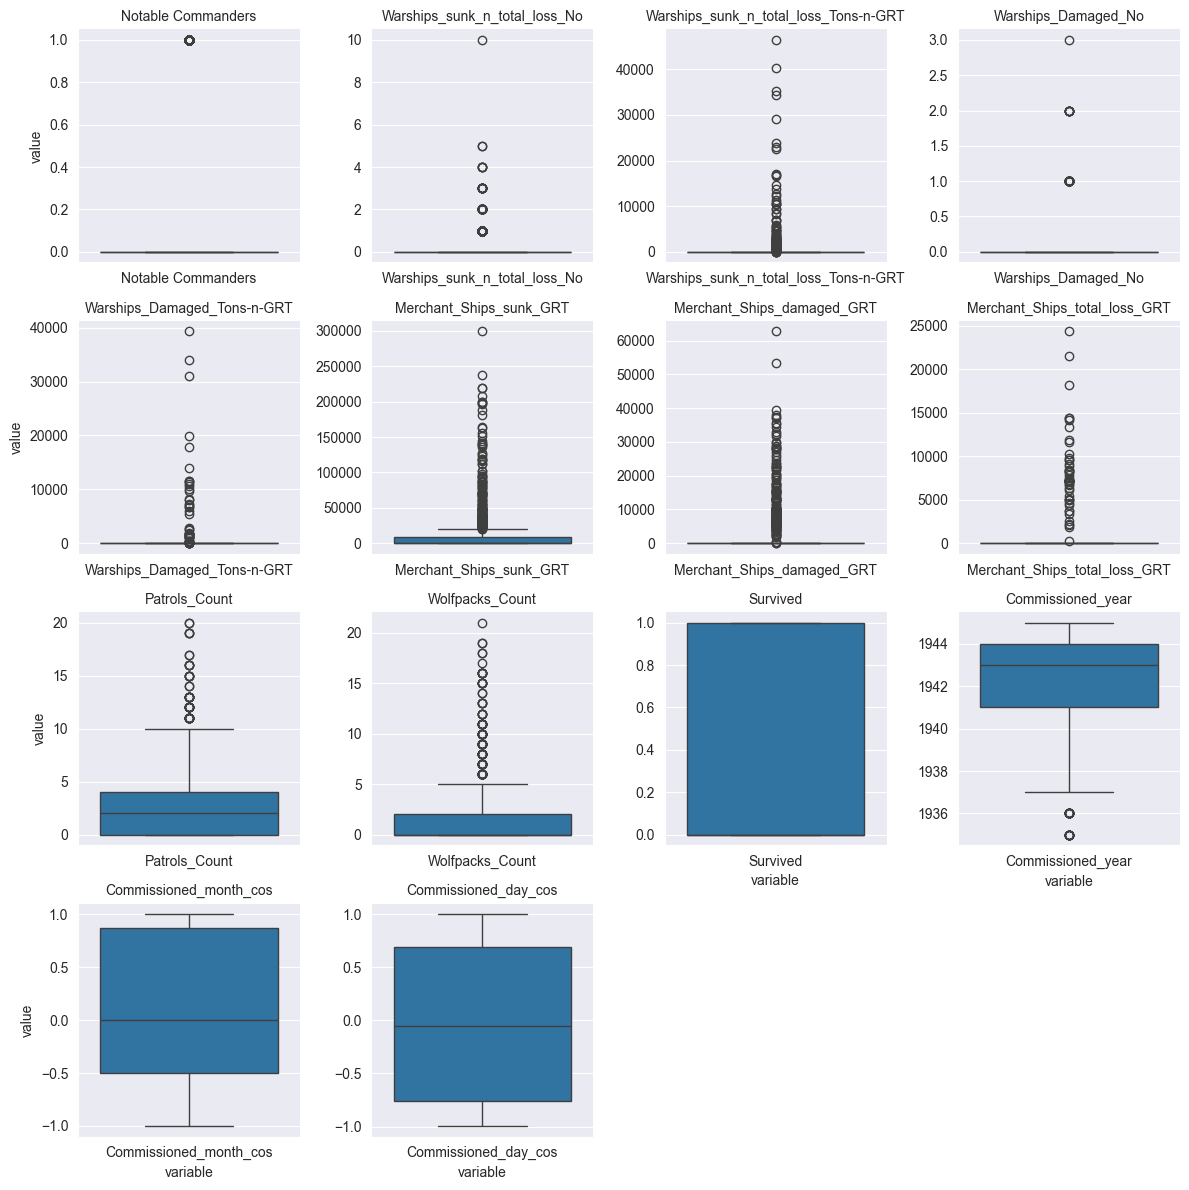

In [781]:
# box plots for numerical columns using FacetGrid
g = sns.FacetGrid(df_encoded_no_cat.melt(), col='variable', col_wrap=4, sharex=False, sharey=False)

g.map(sns.boxplot, 'variable', 'value')

g.set_titles('{col_name}')
g.set_axis_labels('variable', 'value')
plt.tight_layout()
plt.show()

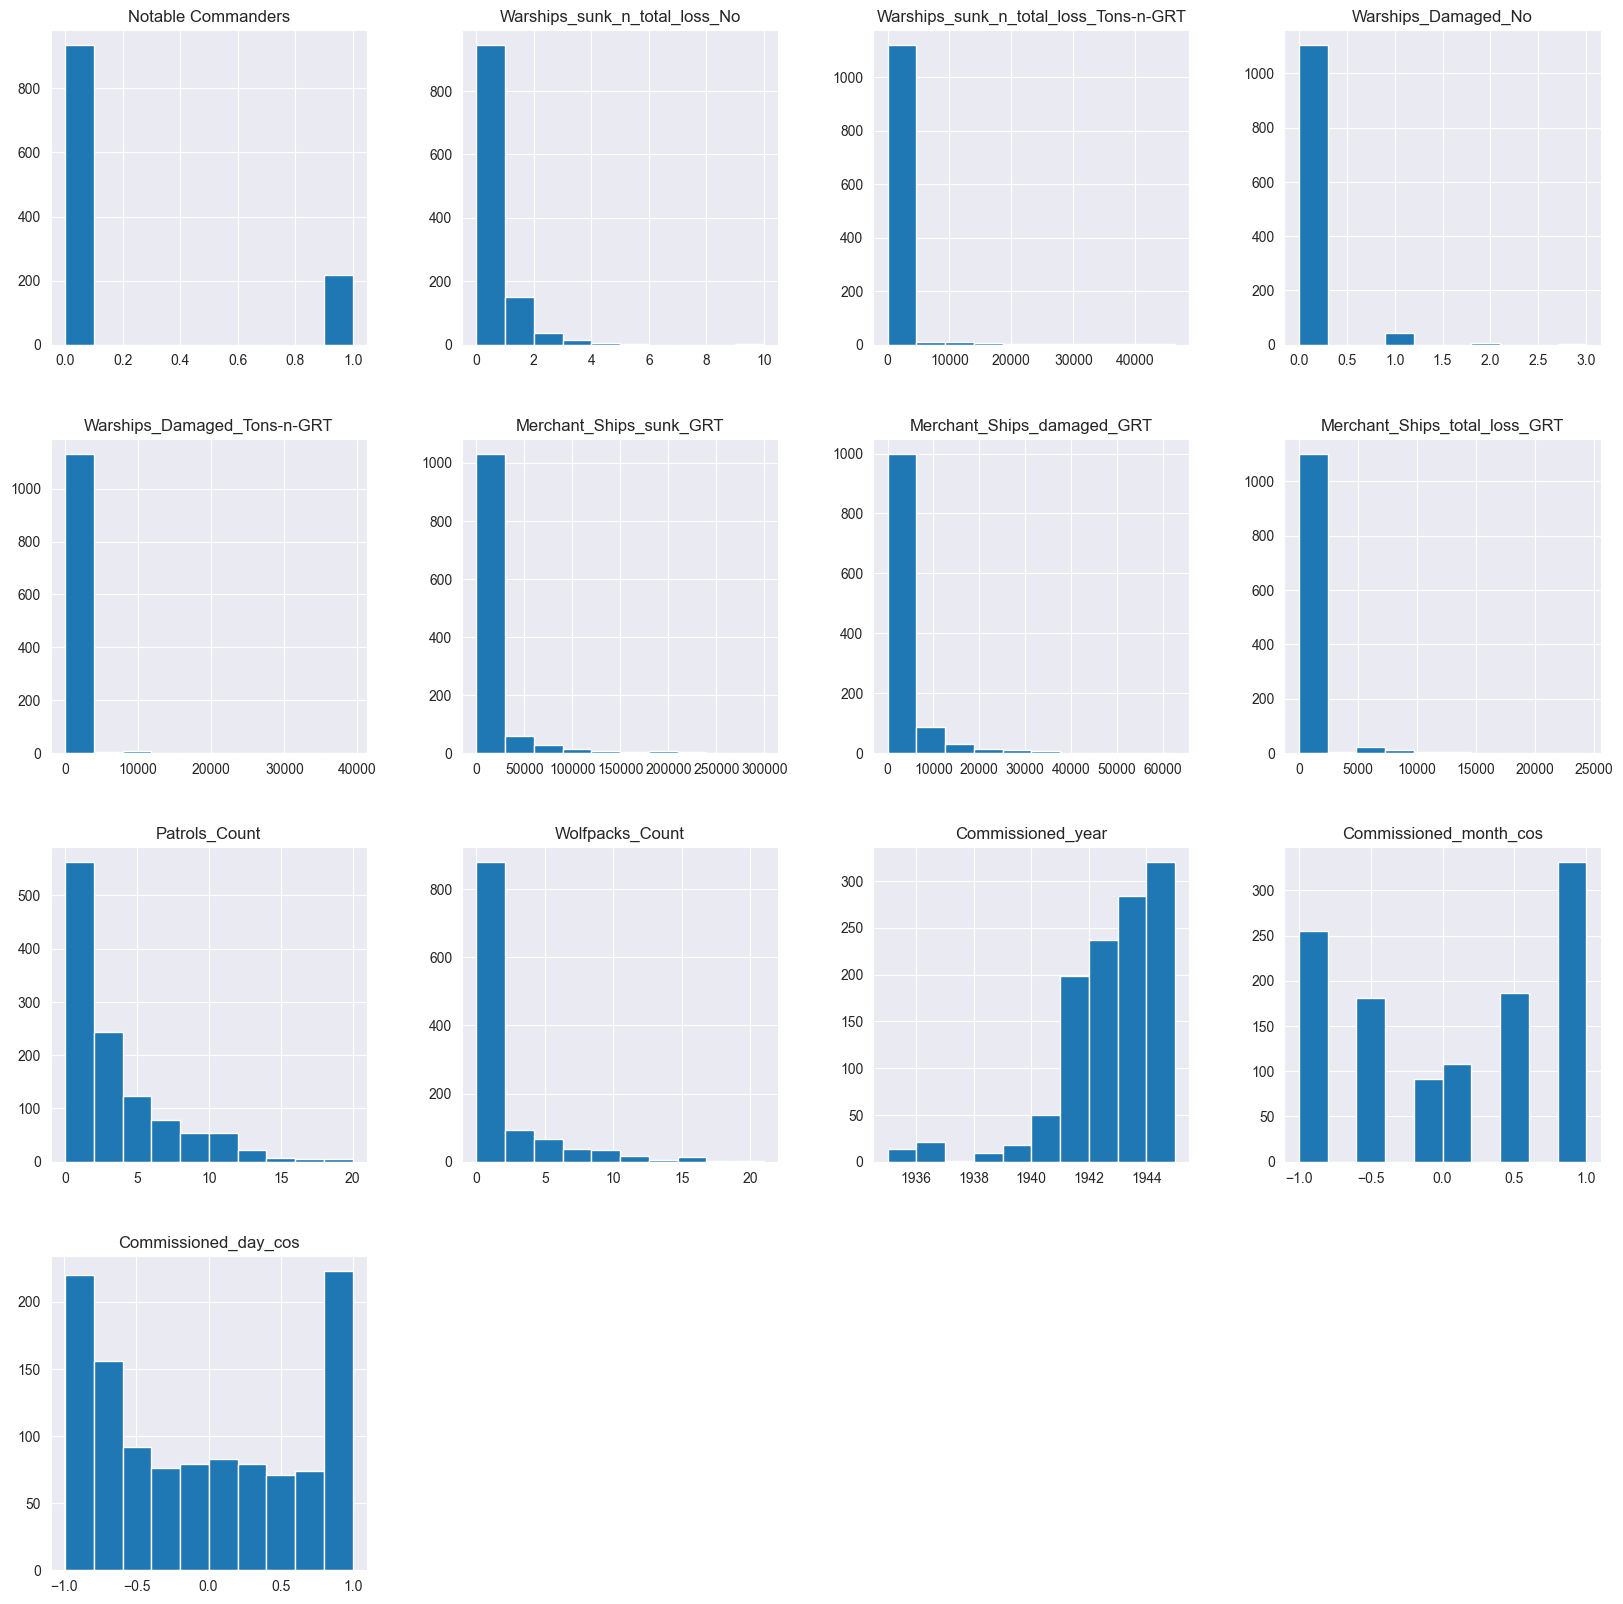

In [782]:
# distribution of numerical columns
df_encoded_no_cat.hist(figsize=(20, 20))
plt.show()

### Scaling
- Hodnoty v datasetu mají různé rozsahy a jednotky
- Vyskytují se zde outlieři
    - Nemusel by být špatný nápad použít RobustScaler


In [785]:
# MinMaxScaler
scaler = MinMaxScaler()
df_encoded_scaled_mm = df_encoded.copy()
df_encoded_scaled_mm[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# RobustScaler
scaler = RobustScaler()
df_encoded_scaled_rs = df_encoded.copy()
df_encoded_scaled_rs[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# StandardScaler
scaler = StandardScaler()
df_encoded_scaled_ss = df_encoded.copy()
df_encoded_scaled_ss[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# Only numerical columns
scaler = MinMaxScaler()
df_encoded_no_cat_scaled_mm = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_mm = scaler.fit_transform(df_encoded_no_cat)

scaler = RobustScaler()
df_encoded_no_cat_scaled_rs = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_rs = scaler.fit_transform(df_encoded_no_cat)

scaler = StandardScaler()
df_encoded_no_cat_scaled_ss = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_ss = scaler.fit_transform(df_encoded_no_cat)


In [786]:
df_encoded_no_cat_scaled_ss

array([[ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -1.50657835,  1.39053349],
       [ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -1.31697697,  0.56118192],
       [ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -0.09137439,  0.56118192],
       ...,
       [ 2.07098789, -0.37770241, -0.1978444 , ...,  1.41622517,
        -1.31697697,  1.47841133],
       [-0.48286135, -0.37770241, -0.1978444 , ...,  1.41622517,
        -0.09137439, -0.58160968],
       [-0.48286135, -0.37770241, -0.1978444 , ...,  1.41622517,
        -0.79897637,  1.24807344]])

## Klasifikace
- V preprocesingu byla vytvořena cílová proměná a byly odebrány atributy ze kterých byla vytvořena
- Nabízí se několik možných cílových proměnných
- Například:
    - Typ ponorky
    - Množství potopených válečných/obchodních lodí
    - Osud ponorky
    - Počet dnů ve službě   
- Byla vybrána cílová proměnná, zda ponorka přežila do konce války. 
- Za ponorky, které přežily do konce války jsou považovány ty, které se vzdaly po 30. dubnu 1945 nebo měly libovolný osud po 8. květnu 1945.
    - Ponorky, které měli libovolný osud po 8.květnu 1945  jsou považovány za přeživší vždy, protože se v datasetu vyskytují ponorky, které mají osud 'Sunken', ale byly potopené poté co se vzdaly.
    -  Ruční kontrola by byla příliž časově náročná a proto byla vybrána tato metoda, ikdyž může být v některých případech chybná
- Oficiální kapitualace německa byla sice až 7 a 9 května 1945, ale po nástupu Karla Dönitze do čela státu se mnoho ponorek vzdalo nebo bylo cíleně zničeno 
- Určitě zde bude velké zastoupení ponorek vyrobených ke konci války. Ale jinak by mělo být zajímavé zjistit, jaké atributy mají vliv na přežití ponorky.

### Vyvážení cílové proměnné

In [ ]:
# Distribution of target variable
df_encoded['Survived'].value_counts()

### Zvolená metrika